In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import tifffile
import plotly.express as px
import glob

# Load data, filter, and normalize

In [2]:
imgs = np.array([tifffile.imread(f) for f in glob.glob('*analysis/Exported_his/*plate*/*.tif')])

In [3]:
names = np.array([f for f in glob.glob('*analysis/Exported_his/*plate*/*.tif')])

In [4]:
norm = np.sum(np.sum(imgs, axis=1), axis=1)

In [5]:
normed = imgs/norm[:,np.newaxis, np.newaxis]*10000.0
normed = np.nan_to_num(normed, 0)

/scratch/smc/miniconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


(array([822., 374., 715., 962., 809., 560., 508., 216.,  65.,  12.]),
 array([     0. ,  40054.7,  80109.4, 120164.1, 160218.8, 200273.5,
        240328.2, 280382.9, 320437.6, 360492.3, 400547. ], dtype=float32),
 <BarContainer object of 10 artists>)

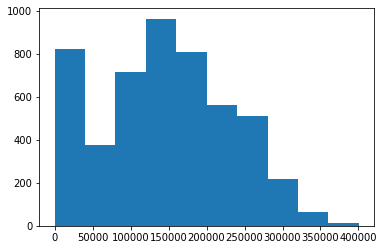

In [6]:
plt.hist(norm)

In [7]:
good_ones = norm>50000

In [8]:
imgs = imgs[good_ones,:,:]
normed = normed[good_ones,:,:]
names = names[good_ones]
norm = norm[good_ones]

# Pytorch

In [9]:
from torch import nn, optim
import torch.nn.functional as F
import torch
from torchvision import datasets, transforms

In [10]:
training_data = np.reshape(normed, [normed.shape[0], 1, normed.shape[1], normed.shape[2]])

In [11]:
base_scaler=32

In [12]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conA1 = nn.Conv2d(1,base_scaler,5,stride=1, padding=2)
        self.conA2 = nn.Conv2d(base_scaler, base_scaler, 3, stride=1, padding=1)
        
        self.conB1 = nn.Conv2d(base_scaler, base_scaler*2, 3, stride=1, padding=1)
        self.conB2 = nn.Conv2d(base_scaler*2, base_scaler*2, 3, stride=1, padding=1)
        
        self.conC1 = nn.Conv2d(base_scaler*2, base_scaler*4, 3, stride=1, padding=1)
        self.conC2 = nn.Conv2d(base_scaler*4, base_scaler*4, 3, stride=1, padding=1)

        self.conD1 = nn.Conv2d(base_scaler*4, base_scaler*8, 3, stride=1, padding=1)
        self.conD2 = nn.Conv2d(base_scaler*8, base_scaler*8, 3, stride=1, padding=1)

        self.conE1 = nn.Conv2d(base_scaler*8, base_scaler*16, 3, stride=1, padding=1)
        self.conE2 = nn.Conv2d(base_scaler*16, base_scaler*16,3, stride=1, padding=1)
        
        self.Lin1 = nn.Linear(in_features=base_scaler*16*8*8, out_features=256)
        self.Lin2 = nn.Linear(in_features=256, out_features=base_scaler*16*8*8)
        
        self.deconEE0 = nn.ConvTranspose2d(base_scaler*16, base_scaler*8, 2, stride=[2,2])
        self.conEE1 = nn.Conv2d(base_scaler*8, base_scaler*8, 3, stride=1, padding=1)
        self.conEE2 = nn.Conv2d(base_scaler*8, base_scaler*8,3, stride=1, padding=1)
        
        self.deconDD0 = nn.ConvTranspose2d(base_scaler*8, base_scaler*8, 2, stride=[2,2])
        self.conDD1 = nn.Conv2d(base_scaler*8, base_scaler*8, 3, stride=1, padding=1)
        self.conDD2 = nn.Conv2d(base_scaler*8, base_scaler*8,3, stride=1, padding=1)

        self.deconCC0 = nn.ConvTranspose2d(base_scaler*8, base_scaler*4, [2,2], stride=[2,2])
        self.conCC1 = nn.Conv2d(base_scaler*4, base_scaler*4, 3, stride=1, padding=1)
        self.conCC2 = nn.Conv2d(base_scaler*4, base_scaler*4, 3, stride=1, padding=1)
        
        self.deconBB0 = nn.ConvTranspose2d(base_scaler*4, base_scaler*2, 2, stride=[2,2])
        self.conBB1 = nn.Conv2d(base_scaler*2, base_scaler*2, 3, stride=1, padding=1)
        self.conBB2 = nn.Conv2d(base_scaler*2, base_scaler*2,3, stride=1, padding=1)

        self.deconAA0 = nn.ConvTranspose2d(base_scaler*2, base_scaler, [2,2], stride=[2,2])
        self.conAA1 = nn.Conv2d(base_scaler, base_scaler, 3, stride=1, padding=1)
        self.conAA2 = nn.Conv2d(base_scaler, 1,3, stride=1, padding=1)
        
        self.maxpool_noZ = nn.MaxPool2d([2,2])
        self.maxpool_Z = nn.MaxPool2d([2,2])
        self.LReLu = nn.LeakyReLU(0.3)
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        self.A = self.LReLu(self.conA2(self.LReLu(self.conA1(x))))
        self.pA = self.maxpool_noZ(self.A)
        
        self.B = self.LReLu(self.conB2(self.LReLu(self.conB1(self.pA))))
        self.pB = self.maxpool_Z(self.B)
        
        self.C = self.LReLu(self.conC2(self.LReLu(self.conC1(self.pB))))
        self.pC = self.maxpool_noZ(self.C)
        
        self.D = self.LReLu(self.conD2(self.LReLu(self.conD1(self.pC))))
        self.pD = self.maxpool_Z(self.D)
        
        self.E = self.LReLu(self.conE2(self.LReLu(self.conE1(self.pD))))
        self.pE = self.maxpool_Z(self.E)
        
        self.preLatent = torch.reshape(self.pE, [-1, base_scaler*16*8*8])
        self.Latent = self.Lin1(self.preLatent)
        self.Lat2 = self.Lin2(self.Latent)
        self.postLatent = torch.reshape(self.Lat2, [-1, base_scaler*16, 8, 8])

        #self.E = self.LReLu(self.conE2(self.LReLu(self.conE1(self.pD))))
        
        self.EE=self.LReLu(self.conEE2(self.LReLu(self.conEE1(self.deconEE0(self.postLatent)))))
        #self.DDc=torch.cat((self.deconDD0(self.E), self.D), 1)
        self.DD=self.LReLu(self.conDD2(self.LReLu(self.conDD1(self.deconDD0(self.EE)))))

        #self.CCc=torch.cat((self.deconCC0(self.DD), self.C), 1)
        self.CC=self.LReLu(self.conCC2(self.LReLu(self.conCC1(self.deconCC0(self.DD)))))
        
        #self.BBc=torch.cat((self.deconBB0(self.CC), self.B), 1)
        self.BB=self.LReLu(self.conBB2(self.LReLu(self.conBB1(self.deconBB0(self.CC)))))
        
        #self.AAc=torch.cat((self.deconAA0(self.BB), self.A), 1)
        self.AA=self.LReLu(self.conAA2(self.LReLu(self.conAA1(self.deconAA0(self.BB)))))
        
        #self.T=self.tanh(self.AA)
        self.T=self.AA
                
        return self.T

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook    

In [13]:
model = AutoEncoder()
model.cuda()
criterion = nn.MSELoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

from torch.optim import lr_scheduler
lambdar = lambda epoch: 0.98 ** epoch
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambdar)

9.8e-05


<Figure size 2160x1152 with 0 Axes>

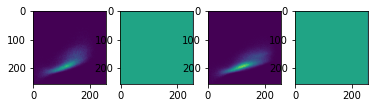

9.604e-05


<Figure size 2160x1152 with 0 Axes>

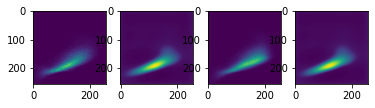

9.41192e-05


<Figure size 2160x1152 with 0 Axes>

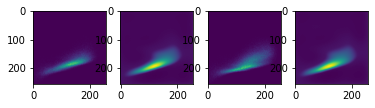

9.2236816e-05


<Figure size 2160x1152 with 0 Axes>

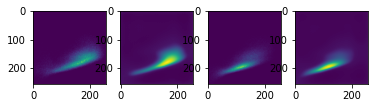

9.039207968e-05


<Figure size 2160x1152 with 0 Axes>

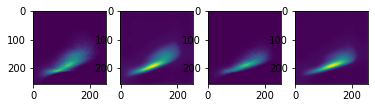

8.858423808639999e-05


<Figure size 2160x1152 with 0 Axes>

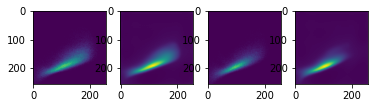

8.681255332467199e-05


<Figure size 2160x1152 with 0 Axes>

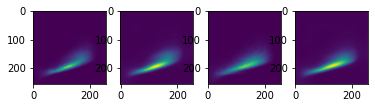

8.507630225817855e-05


<Figure size 2160x1152 with 0 Axes>

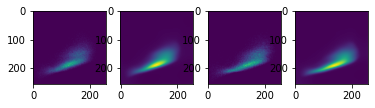

8.337477621301498e-05


<Figure size 2160x1152 with 0 Axes>

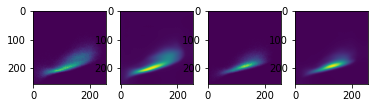

8.170728068875468e-05


<Figure size 2160x1152 with 0 Axes>

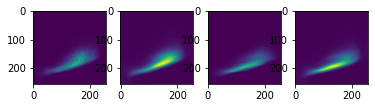

8.00731350749796e-05


<Figure size 2160x1152 with 0 Axes>

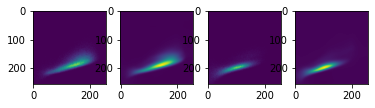

7.847167237347999e-05


<Figure size 2160x1152 with 0 Axes>

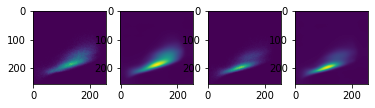

7.690223892601038e-05


<Figure size 2160x1152 with 0 Axes>

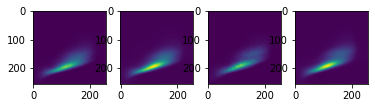

7.536419414749018e-05


<Figure size 2160x1152 with 0 Axes>

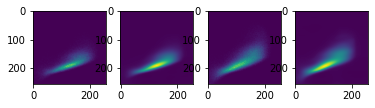

7.385691026454039e-05


<Figure size 2160x1152 with 0 Axes>

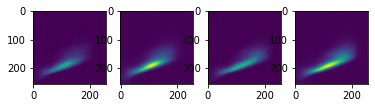

7.237977205924956e-05


<Figure size 2160x1152 with 0 Axes>

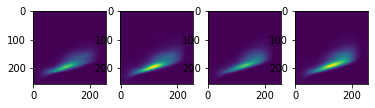

7.093217661806457e-05


<Figure size 2160x1152 with 0 Axes>

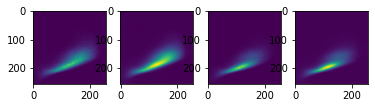

6.951353308570328e-05


<Figure size 2160x1152 with 0 Axes>

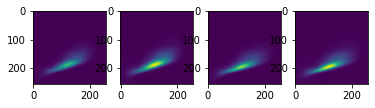

6.812326242398921e-05


<Figure size 2160x1152 with 0 Axes>

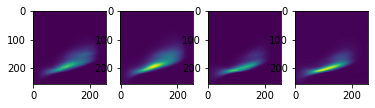

6.676079717550943e-05


<Figure size 2160x1152 with 0 Axes>

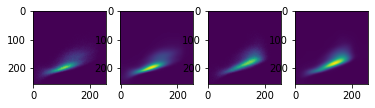

6.542558123199923e-05


<Figure size 2160x1152 with 0 Axes>

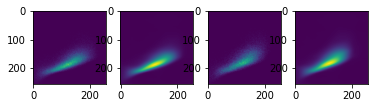

6.411706960735925e-05


<Figure size 2160x1152 with 0 Axes>

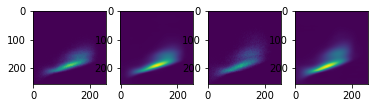

6.283472821521206e-05


<Figure size 2160x1152 with 0 Axes>

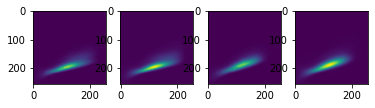

6.157803365090782e-05


<Figure size 2160x1152 with 0 Axes>

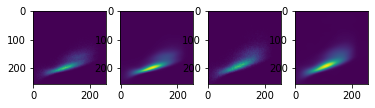

6.034647297788967e-05


<Figure size 2160x1152 with 0 Axes>

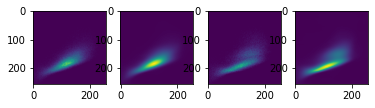

5.9139543518331874e-05


<Figure size 2160x1152 with 0 Axes>

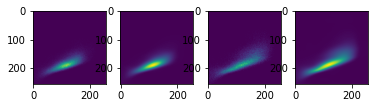

5.795675264796523e-05


<Figure size 2160x1152 with 0 Axes>

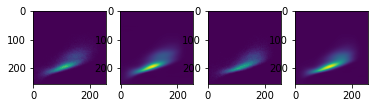

5.6797617595005923e-05


<Figure size 2160x1152 with 0 Axes>

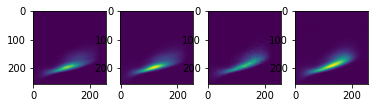

5.566166524310581e-05


<Figure size 2160x1152 with 0 Axes>

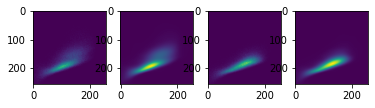

5.454843193824369e-05


<Figure size 2160x1152 with 0 Axes>

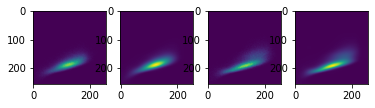

5.345746329947882e-05


<Figure size 2160x1152 with 0 Axes>

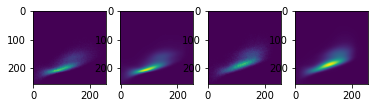

5.2388314033489236e-05


<Figure size 2160x1152 with 0 Axes>

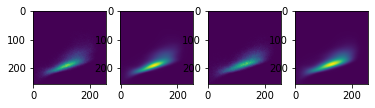

5.1340547752819454e-05


<Figure size 2160x1152 with 0 Axes>

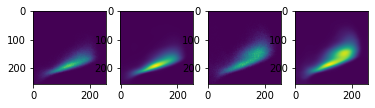

5.0313736797763064e-05


<Figure size 2160x1152 with 0 Axes>

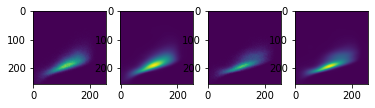

4.93074620618078e-05


<Figure size 2160x1152 with 0 Axes>

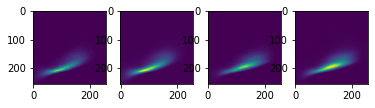

4.8321312820571645e-05


<Figure size 2160x1152 with 0 Axes>

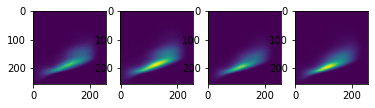

4.7354886564160214e-05


<Figure size 2160x1152 with 0 Axes>

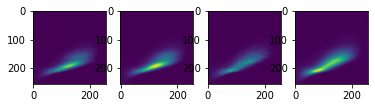

4.6407788832877e-05


<Figure size 2160x1152 with 0 Axes>

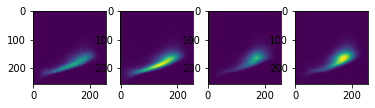

4.547963305621947e-05


<Figure size 2160x1152 with 0 Axes>

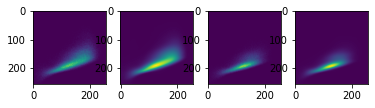

4.4570040395095074e-05


<Figure size 2160x1152 with 0 Axes>

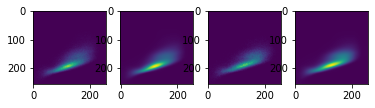

In [14]:
for i in range(0,4000):
    idx=np.random.choice(training_data.shape[0], replace=False, size=[60])
    cur_train=torch.from_numpy(training_data[idx,:,:,:]).float().cuda()
    
    results = model(cur_train)
    loss = criterion(results, cur_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (i%100==0):
        with torch.no_grad():
            scheduler.step()
            for param_group in optimizer.param_groups:
                print(param_group['lr'])
            #valid = model(torch.from_numpy(validation_data).float().cuda()).cpu().numpy()
            plt.figure(figsize=[30,16])
            f, axarr = plt.subplots(1,4) 
            axarr[0].imshow(cur_train[0,0].cpu().numpy())
            axarr[1].imshow(results[0,0].cpu().numpy())
            axarr[2].imshow(cur_train[1,0].cpu().numpy())
            axarr[3].imshow(results[1,0].cpu().numpy())
            plt.show()
            
            #valid = np.concatenate([model(torch.from_numpy(validation_data[(i*30):(i*30+30)]).float().cuda()).cpu().numpy() 
                   #for i in range(0,int(np.ceil(validation_data.shape[0]/30)))])
            #torch.save(model.state_dict(), data+'PT_weights_'+str(i).zfill(4)+'.pth')
            

In [15]:
torch.save(model.state_dict(), 'PT_weights'+'.pth')

# Apply pytorch model

In [16]:
model = AutoEncoder()
model.cuda()

model.load_state_dict(torch.load('PT_weights.pth'))

model.Lin1.register_forward_hook(get_activation('Lin1'))

model.eval()

AutoEncoder(
  (conA1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conA2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conB1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conB2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conC1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conC2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conD1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conD2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conE1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conE2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Lin1): Linear(in_features=32768, out_features=256, bias=True)
  (Lin2): Linear(in_features=256, out_features=32768, bias=True)
  (deconEE0): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=[2, 2])
  

In [17]:
with torch.no_grad():
    results = np.concatenate([model(torch.from_numpy(training_data[(i*30):(i*30+30)]).float().cuda()).cpu().numpy() 
                   for i in range(0,int(np.ceil(training_data.shape[0]/30)))])


In [18]:
latents = []
for i in range(0,int(np.ceil(training_data.shape[0]/30))):
    tmp = model(torch.from_numpy(training_data[(i*30):(i*30+30)]).float().cuda())
    latents.append(activation['Lin1'].cpu().numpy())

latents = np.concatenate(latents)

Text(0.5, 1.0, '1146')

<Figure size 1080x576 with 0 Axes>

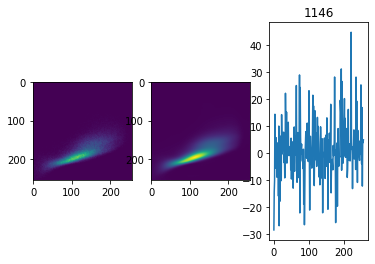

In [19]:
idx = np.random.choice(training_data.shape[0], size=1)[0]

plt.figure(figsize=[15,8])
f, axarr = plt.subplots(1,3) 
axarr[0].imshow(training_data[idx,0])
axarr[1].imshow(results[idx,0])
axarr[2].plot(latents[idx])
plt.title(idx)

In [20]:
np.save('Original.npy', training_data)
np.save('Encoded.npy', results)
np.save('Latents.npy', latents)
np.save('Names.npy', names)